In [1]:
from my_trader import *

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/fix_yahoo_finance/__init__.py:43: DeprecationWarning: 
    Auto-overriding of pandas_datareader's get_data_yahoo() is deprecated and no longer available.
    Use pdr_override() to explicitly override it.
  DeprecationWarning)


In [49]:
robinhood = get_robinhood()
stock1 = "VIXY"
stock2 = "SPY"
window = 39
initial = 1500


price1 = get_price_data([stock1],method="day")
price2 = get_price_data([stock2],method="day")
price1 = price1.set_index("TimeStamp")
price2 = price2.set_index("TimeStamp")
price1 = price1.rename(columns={"Close":stock1+"_close"})
price2 = price2.rename(columns={"Close":stock2+"_close"})



price_table = pd.concat([price1[stock1+"_close"],price2[stock2+"_close"]],axis = 1)
price_table[stock1+"_close"] = price_table[stock1+"_close"].astype(float)
price_table[stock2+"_close"] = price_table[stock2+"_close"].astype(float)
price_table[stock1+"_log_ret"] = log(price_table[stock1+"_close"] / price_table[stock1+"_close"].shift(1))
price_table[stock2+"_log_ret"] = log(price_table[stock2+"_close"] / price_table[stock2+"_close"].shift(1))
price_table[stock1+"_log_ret_mv"] = price_table[stock1+"_log_ret"].rolling(window).mean()
price_table[stock2+"_log_ret_mv"] =price_table[stock2+"_log_ret"].rolling(window).mean()
price_table["relative"]=price_table[stock1+"_log_ret"]/price_table[stock2+"_log_ret"]
price_table["relative_mv"] = price_table["relative"].rolling(window).mean()
#price_table["relative_mv"]=price_table[stock1+"_log_ret_mv"]/price_table[stock2+"_log_ret_mv"]
price_table["z_score"] =( price_table["relative"]-price_table["relative_mv"])/price_table.relative.std()
price_table["trade"]=np.NaN
price_table["trade_signal"]=np.NaN
price_table["slope"]=np.NaN
for i in range(window-1,len(price_table)):
    price_table["slope"].iloc[i] = stats.linregress(price_table[stock1+"_log_ret"]\
                                                    .iloc[i-(window-1):i],price_table[stock2+"_log_ret"].iloc[i-(window-1):i])[0]
price_table["buy_line"] = np.NaN
for i in range(window-1,len(price_table)):
    if price_table.slope.iloc[i]>0.5:
        price_table["buy_line"].iloc[i] = -1.25
    elif price_table.slope.iloc[i]>0.75:
        price_table["buy_line"].iloc[i]= -1.75
    elif price_table.slope.iloc[i]<-0.5:
        price_table["buy_line"].iloc[i] -2.25
    elif price_table.slope.iloc[i]<-0.75:
        price_table["buy_line"].iloc[i]= -2.75
    else:
        price_table["buy_line"].iloc[i] = -2
price_table["sell_line"] = np.NaN
for i in range(window-1,len(price_table)):
    if price_table.slope.iloc[i]>0.5:
        price_table["sell_line"].iloc[i] = 1.25
    elif price_table.slope.iloc[i]>0.75:
        price_table["sell_line"].iloc[i] = 1.75
    elif price_table.slope.iloc[i]<-0.5:
        price_table["sell_line"].iloc[i] = 2.25
    elif price_table.slope.iloc[i]<-0.75:
        price_table["sell_line"].iloc[i] = 2.75
    else:
        price_table["sell_line"].iloc[i] = 2  
#set live trade signal and backtest 
for i in range(window-1,len(price_table)):
    if price_table.z_score.iloc[i] < price_table.buy_line.iloc[i]:
        price_table.trade.iloc[i] = 1
        price_table.trade_signal.iloc[i] = 1
    elif price_table.z_score.iloc[i] > price_table.sell_line.iloc[i]:
        price_table.trade.iloc[i] = 0
        price_table.trade_signal.iloc[i] = 0
    else:
        price_table.trade.iloc[i] = price_table.trade.iloc[i-1]

        
#no short sell

price_table["relative_mv"] = abs(price_table["relative_mv"])

        
#price_table["cost_per_trade"] =abs( price_table[stock1+"_close"]+price_table[stock2+"_close"]*price_table["relative_mv"])
price_table[stock1+"_shares"] = np.ceil((initial/(1+price_table["relative_mv"])/price_table[stock1+"_close"]))
price_table[stock2+"_shares"] = np.ceil((initial/(1+price_table["relative_mv"])*price_table["relative_mv"]/price_table[stock2+"_close"]))
price_table[stock1+"_value"] = price_table[stock1+"_shares"]*price_table[stock1+"_close"]
price_table[stock2+"_value"] = price_table[stock2+"_shares"]*price_table[stock2+"_close"]

price_table["p_L"] = price_table[stock1+"_value"].shift(1) * price_table[stock1+"_log_ret"].shift(1)*price_table.trade.shift(1) +  \
price_table[stock2+"_value"].shift(1) * price_table[stock2+"_log_ret"].shift(1)*price_table.trade.shift(1)

Finished VIXY
Finished SPY


In [50]:
price_table

,VIXY_close,SPY_close,VIXY_log_ret,SPY_log_ret,VIXY_log_ret_mv,SPY_log_ret_mv,relative,relative_mv,z_score,trade,trade_signal,slope,buy_line,sell_line,VIXY_shares,SPY_shares,VIXY_value,SPY_value,p_L
TimeStamp,,,,,,,,,,,,,,,,,,,
2017-11-08,27.850000,257.792297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-09,28.270000,256.857086,0.014968,-0.003634,NaN,NaN,-4.118519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-10,28.900000,256.777496,0.022040,-0.000310,NaN,NaN,-71.119007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-13,28.990000,257.016266,0.003109,0.000929,NaN,NaN,3.345402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-14,29.219999,256.419342,0.007902,-0.002325,NaN,NaN,-3.398579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-15,30.290001,255.135880,0.035964,-0.005018,NaN,NaN,-7.167209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-16,29.059999,257.304779,-0.041455,0.008465,NaN,NaN,-4.897212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-17,28.600000,256.548645,-0.015956,-0.002943,NaN,NaN,5.421652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-20,27.700001,256.986420,-0.031974,0.001705,NaN,NaN,-18.753817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
price_table.to_csv("price_table.csv")

In [16]:
beta(["SPY"])

(     Beta
 SPY   1.0, array([[  3.54935685e-05,   3.54935685e-05],
        [  3.54935685e-05,   3.54935685e-05]]), [0.005957647901275444])

In [37]:
beta(["VIXY"])

(          Beta
 VIXY -0.883393, array([[  6.25742912e-05,  -3.31949627e-04],
        [ -3.31949627e-04,   2.25652577e-03]]), [0.047502902712985122])

In [44]:
robinhood.my_trader.quote_data("VIXY")

{u'adjusted_previous_close': u'27.3100',
 u'ask_price': u'47.0000',
 u'ask_size': 500,
 u'bid_price': u'40.5000',
 u'bid_size': 3000,
 u'has_traded': True,
 u'instrument': u'https://api.robinhood.com/instruments/869251ff-fb17-40c6-9d24-9ab7636dd3d6/',
 u'last_extended_hours_trade_price': u'44.5100',
 u'last_trade_price': u'36.6600',
 u'last_trade_price_source': u'consolidated',
 u'previous_close': u'27.3100',
 u'previous_close_date': u'2018-02-02',
 u'symbol': u'VIXY',
 u'trading_halted': False,
 u'updated_at': u'2018-02-06T01:00:00Z'}

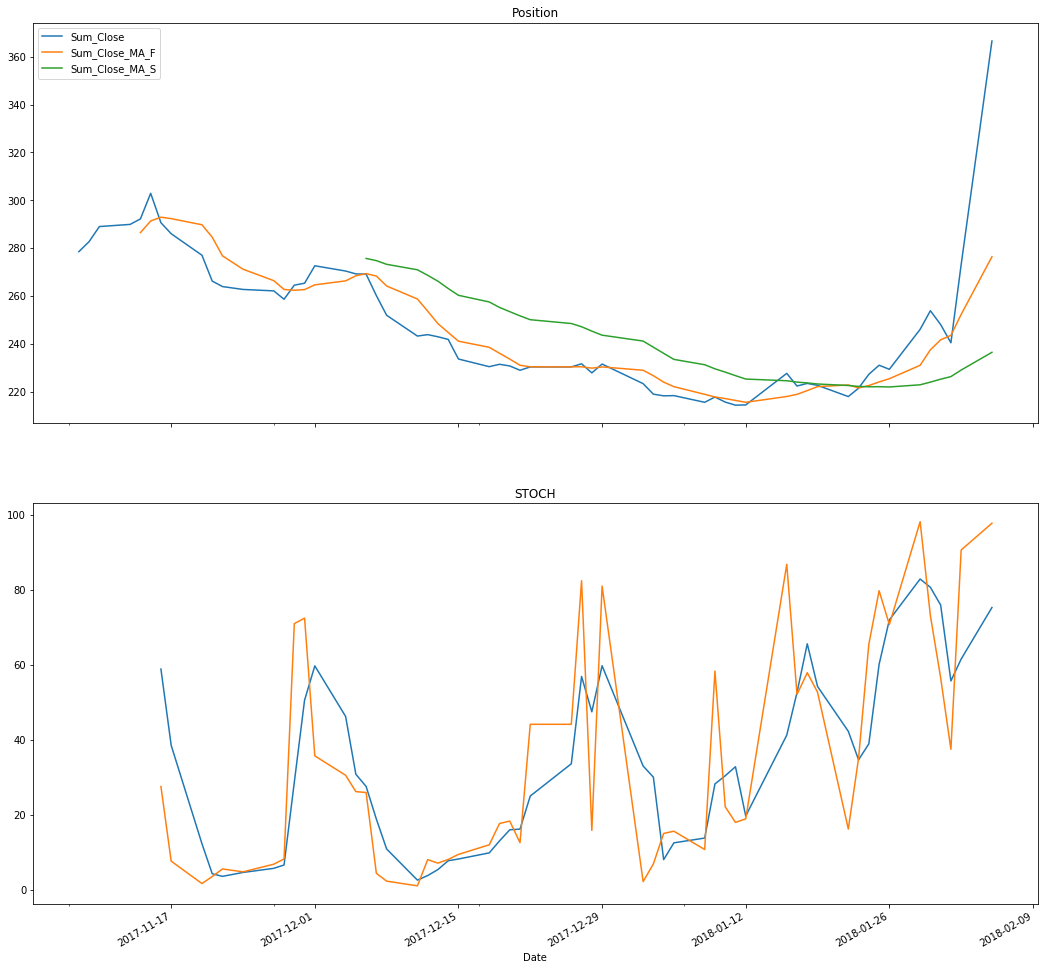

            VIXY_Close  VIXY_High   VIXY_Low  Sum_Close   Sum_High    Sum_Low  \
Date                                                                            
2017-11-08   278.50000  282.80001  275.49999  278.50000  282.80001  275.49999   
2017-11-09   282.70000  297.99999  282.00001  282.70000  297.99999  282.00001   
2017-11-10   289.00000  291.10001  284.00000  289.00000  291.10001  284.00000   
2017-11-13   289.90000  294.40001  285.30001  289.90000  294.40001  285.30001   
2017-11-14   292.19999  299.80000  290.80000  292.19999  299.80000  290.80000   

            Sum_Close_MA_F  Sum_Close_MA_S  STOCH_slowk  STOCH_slowd  
Date                                                                  
2017-11-08             NaN             NaN          NaN          NaN  
2017-11-09             NaN             NaN          NaN          NaN  
2017-11-10             NaN             NaN          NaN          NaN  
2017-11-13             NaN             NaN          NaN          NaN  
2017-1

In [45]:
plot_position(["VIXY"],[10])